In [21]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import clear_output

In [2]:
def lirinzel_ns(v2, a2, IP3, d5, k3, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 100, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

In [7]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1, std=1.0):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.std = std
        mean = 0.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, std, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features, std=std)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

# PINN-1

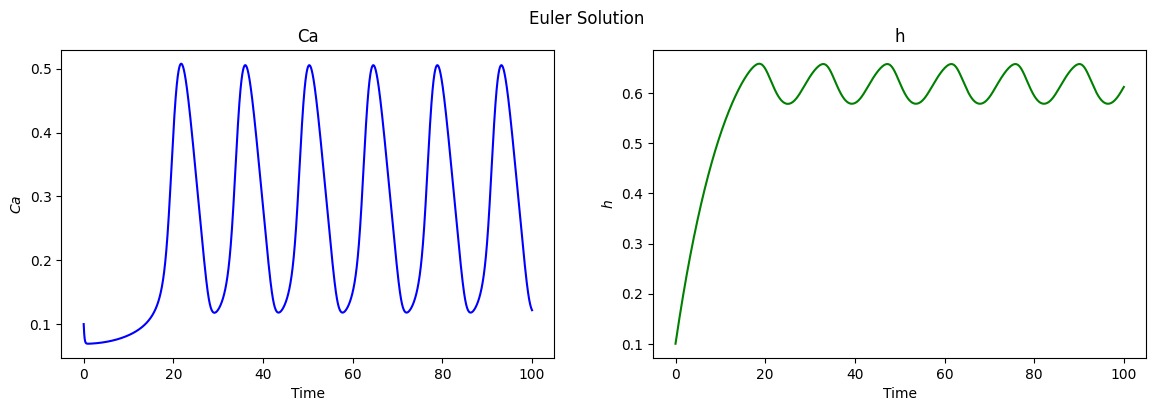

In [4]:
v2 = 0.20
a2 = 0.15
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Training step: 5000
Loss = 6.801661243116541e-07 | Physics_loss = 4.9383346777176484e-05| Initial_loss = 0.0 | Data_loss = 1.8633265426615253e-05


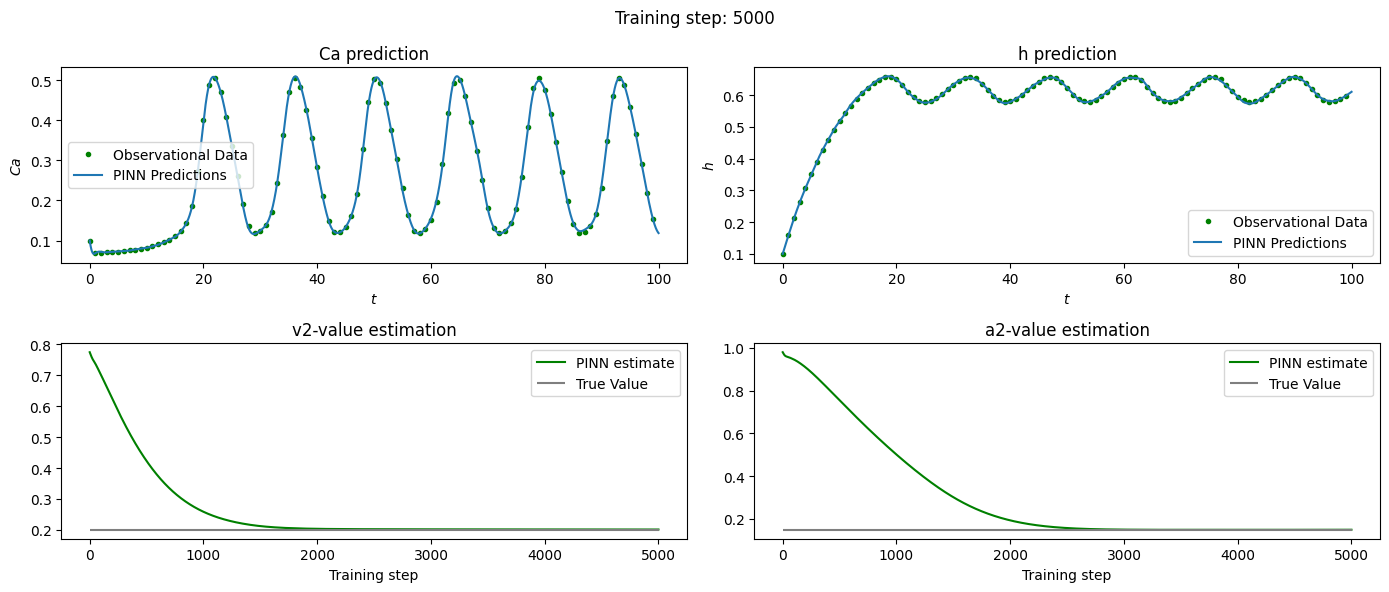

In [9]:
torch.manual_seed(42)
pinn1 = PinnModel(hidden_units=30, num_features=3, std=1.0, y0=torch.tensor([0.1, 0.1]).view(1,-1))

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.20
#a2 = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn1.parameters()) + [v2, a2], lr=0.001)
epochs =  5001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn1.train()

    # Data loss
    sol = pinn1(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn1(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn1(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn1(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 500 == 0:
        
        clear_output(wait=True)
        
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn1.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn1(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.20, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.15, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


# PINN-2

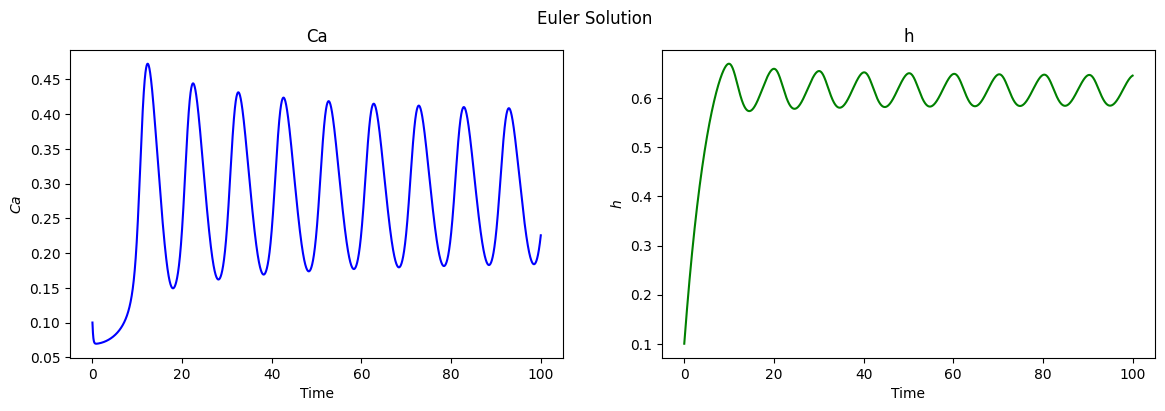

In [73]:
v2 = 0.20
a2 = 0.30
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Training step: 5000
Loss = 7.034287250462512e-07 | Physics_loss = 5.8245015679858625e-05| Initial_loss = 0.0 | Data_loss = 1.209786205436103e-05


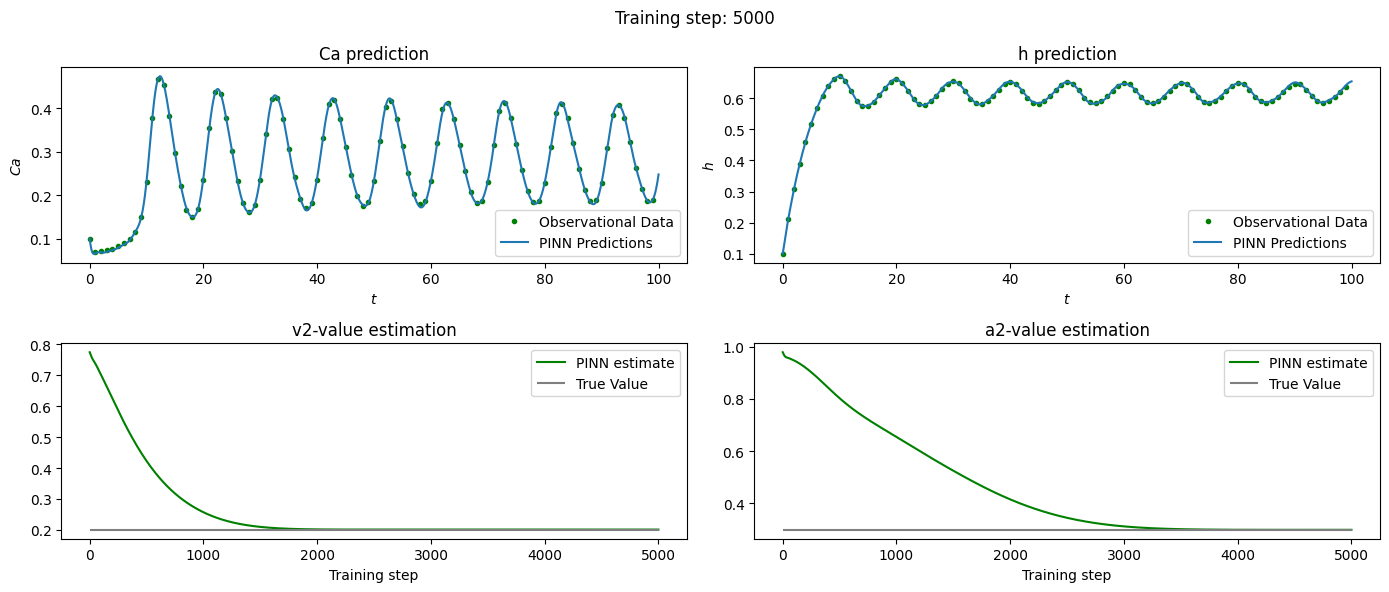

In [74]:
torch.manual_seed(42)
pinn2 = PinnModel(hidden_units=30, num_features=3, std=1.0, y0=torch.tensor([0.1, 0.1]).view(1,-1))

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.20
#a2 = 0.30

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn2.parameters()) + [v2, a2], lr=0.001)
epochs =  5001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn2.train()

    # Data loss
    sol = pinn2(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn2(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn2(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn2(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 500 == 0:
        
        clear_output(wait=True)
        
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn2.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn2(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.20, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.30, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


# PINN-3

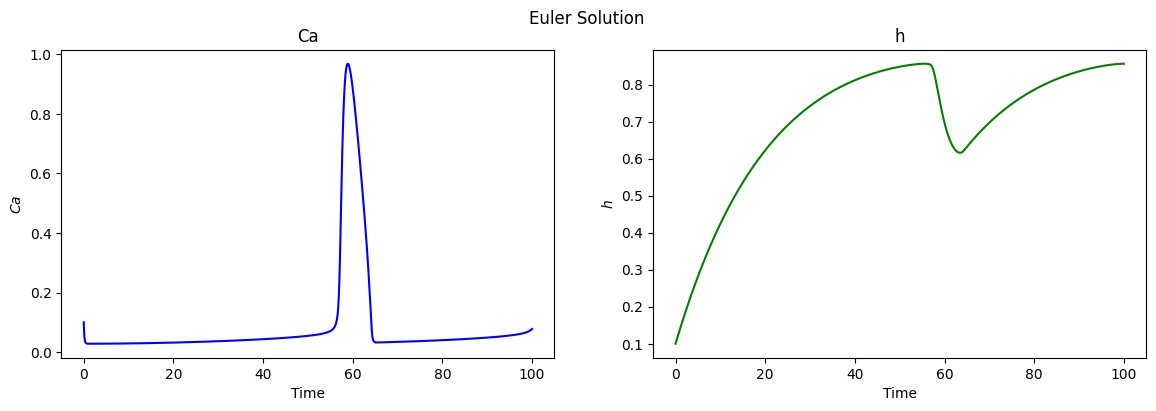

In [80]:
v2 = 0.05
a2 = 0.10
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Training step: 5000
Loss = 3.996013219875749e-06 | Physics_loss = 0.00036933476803824306| Initial_loss = 0.0 | Data_loss = 3.0266564863268286e-05


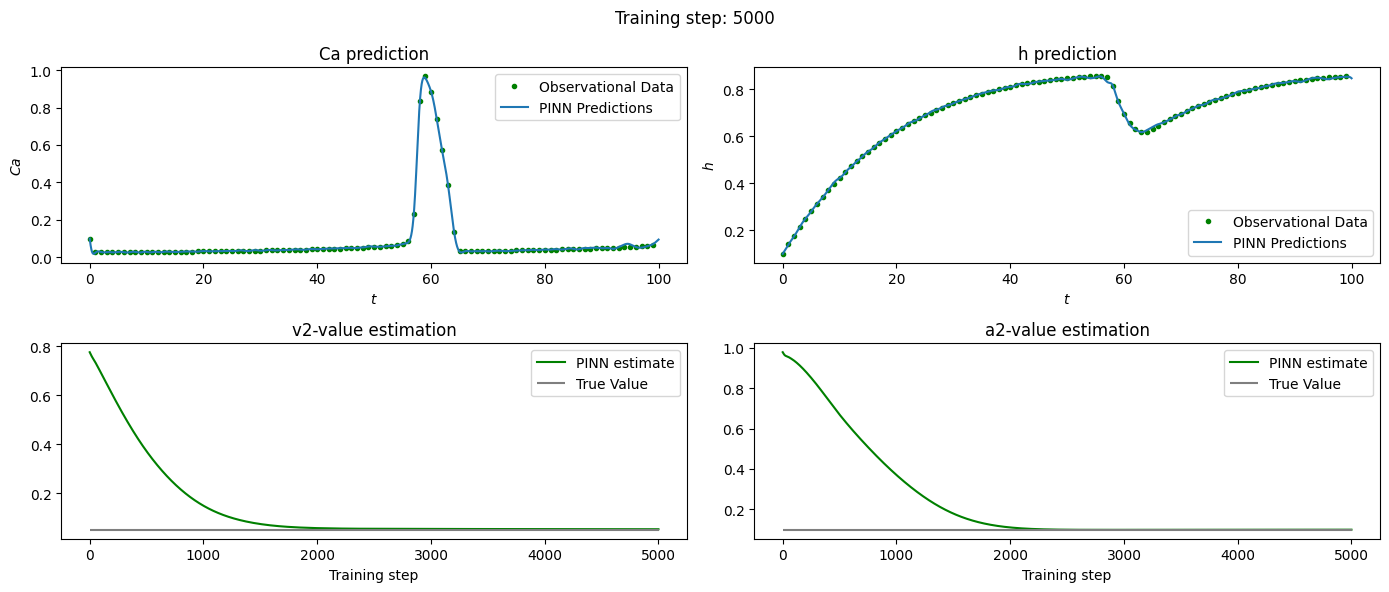

In [81]:
torch.manual_seed(42)
pinn3 = PinnModel(hidden_units=30, num_features=3, std=1.0, y0=torch.tensor([0.1, 0.1]).view(1,-1))

Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]
t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.05
#a2 = 0.10

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn3.parameters()) + [v2, a2], lr=0.001)
epochs =  5001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn3.train()

    # Data loss
    sol = pinn3(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn3(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn3(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn3(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 500 == 0:
        
        clear_output(wait=True)
        
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn3.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn3(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.05, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.10, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()


# Bias Comparison

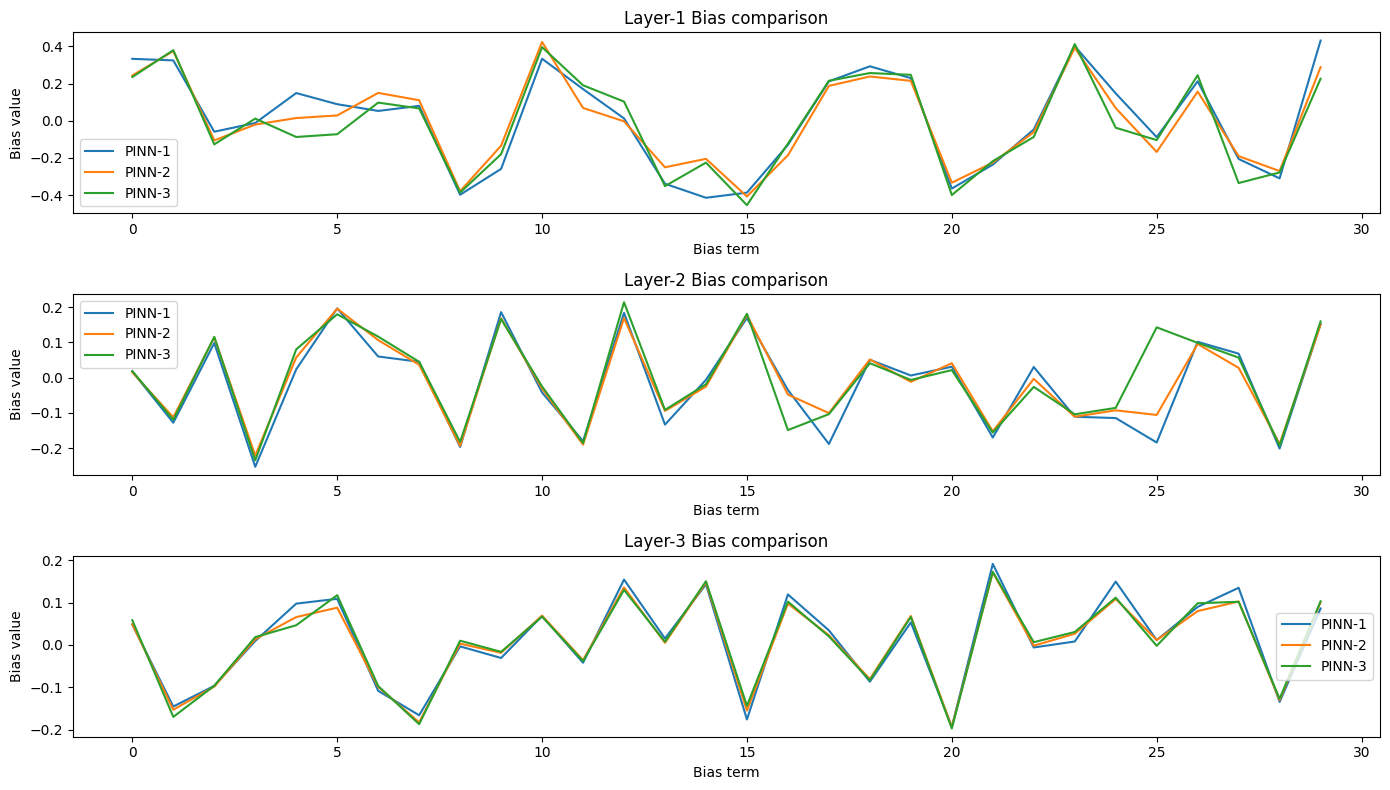

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(311)
plt.title("Layer-1 Bias comparison")
plt.plot(pinn1.layer1.bias.detach().numpy().flatten(), label="PINN-1")
plt.plot(pinn2.layer1.bias.detach().numpy().flatten(), label="PINN-2")
plt.plot(pinn3.layer1.bias.detach().numpy().flatten(), label="PINN-3")
plt.xlabel("Bias term")
plt.ylabel("Bias value")
plt.legend()

plt.subplot(312)
plt.title("Layer-2 Bias comparison")
plt.plot(pinn1.layer2.bias.detach().numpy().flatten(), label="PINN-1")
plt.plot(pinn2.layer2.bias.detach().numpy().flatten(), label="PINN-2")
plt.plot(pinn3.layer2.bias.detach().numpy().flatten(), label="PINN-3")
plt.xlabel("Bias term")
plt.ylabel("Bias value")
plt.legend()

plt.subplot(313)
plt.title("Layer-3 Bias comparison")
plt.plot(pinn1.layer3.bias.detach().numpy().flatten(), label="PINN-1")
plt.plot(pinn2.layer3.bias.detach().numpy().flatten(), label="PINN-2")
plt.plot(pinn3.layer3.bias.detach().numpy().flatten(), label="PINN-3")
plt.xlabel("Bias term")
plt.ylabel("Bias value")
plt.legend()

plt.tight_layout()
plt.show()

# Weights Comparison

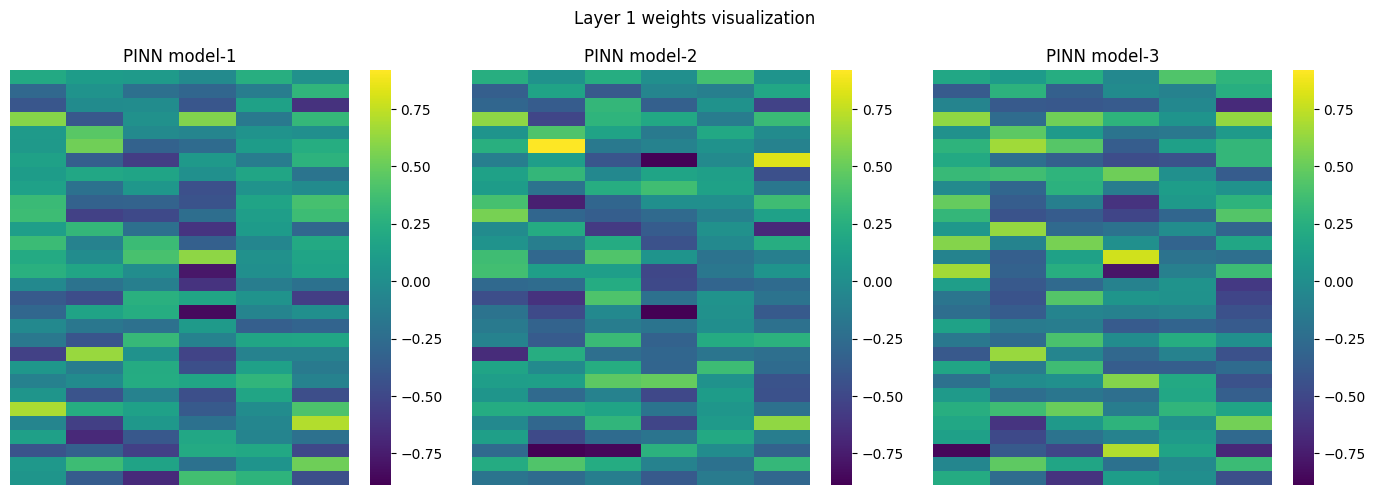

In [103]:
data_matrix1 = pinn1.layer1.weight.detach().numpy()
data_matrix2 = pinn2.layer1.weight.detach().numpy()
data_matrix3 = pinn3.layer1.weight.detach().numpy()
vmin = min(data_matrix1.min(), data_matrix2.min(), data_matrix3.min())
vmax = max(data_matrix1.max(), data_matrix2.max(), data_matrix3.max())

plt.figure(figsize=(14,5))
plt.suptitle("Layer 1 weights visualization")

plt.subplot(131)
plt.title("PINN model-1")
sns.heatmap(data_matrix1, annot=False, vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.subplot(132)
plt.title("PINN model-2")
sns.heatmap(data_matrix2, annot=False,  vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.subplot(133)
plt.title("PINN model-3")
sns.heatmap(data_matrix3, annot=False,  vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.tight_layout()
plt.show()

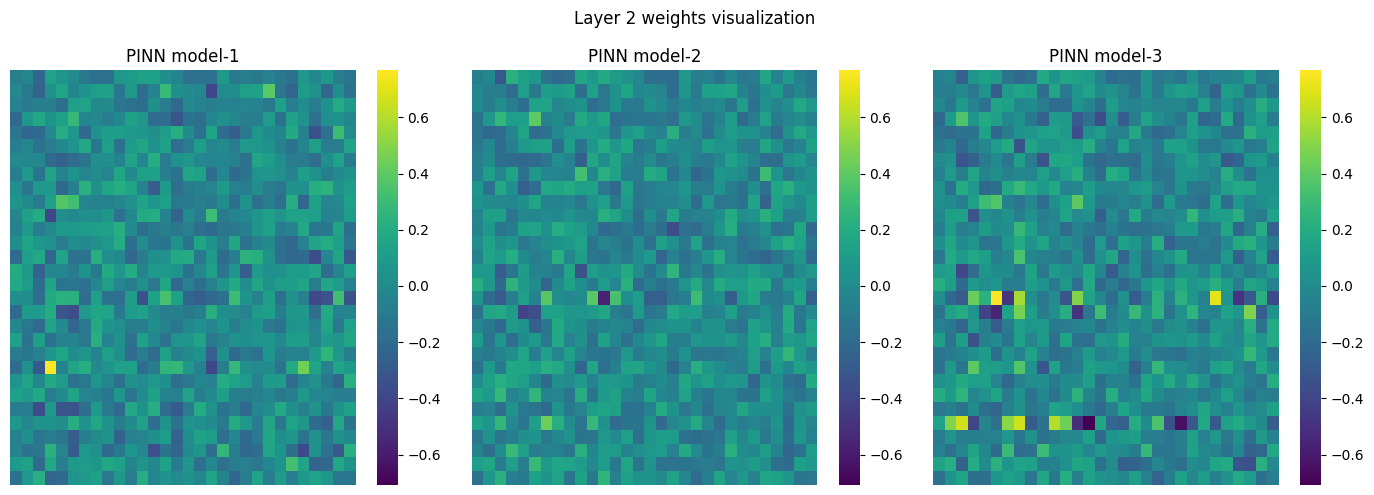

In [104]:
data_matrix1 = pinn1.layer2.weight.detach().numpy()
data_matrix2 = pinn2.layer2.weight.detach().numpy()
data_matrix3 = pinn3.layer2.weight.detach().numpy()
vmin = min(data_matrix1.min(), data_matrix2.min(), data_matrix3.min())
vmax = max(data_matrix1.max(), data_matrix2.max(), data_matrix3.max())

plt.figure(figsize=(14,5))
plt.suptitle("Layer 2 weights visualization")

plt.subplot(131)
plt.title("PINN model-1")
sns.heatmap(data_matrix1, annot=False, vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.subplot(132)
plt.title("PINN model-2")
sns.heatmap(data_matrix2, annot=False,  vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.subplot(133)
plt.title("PINN model-3")
sns.heatmap(data_matrix3, annot=False,  vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.tight_layout()
plt.show()

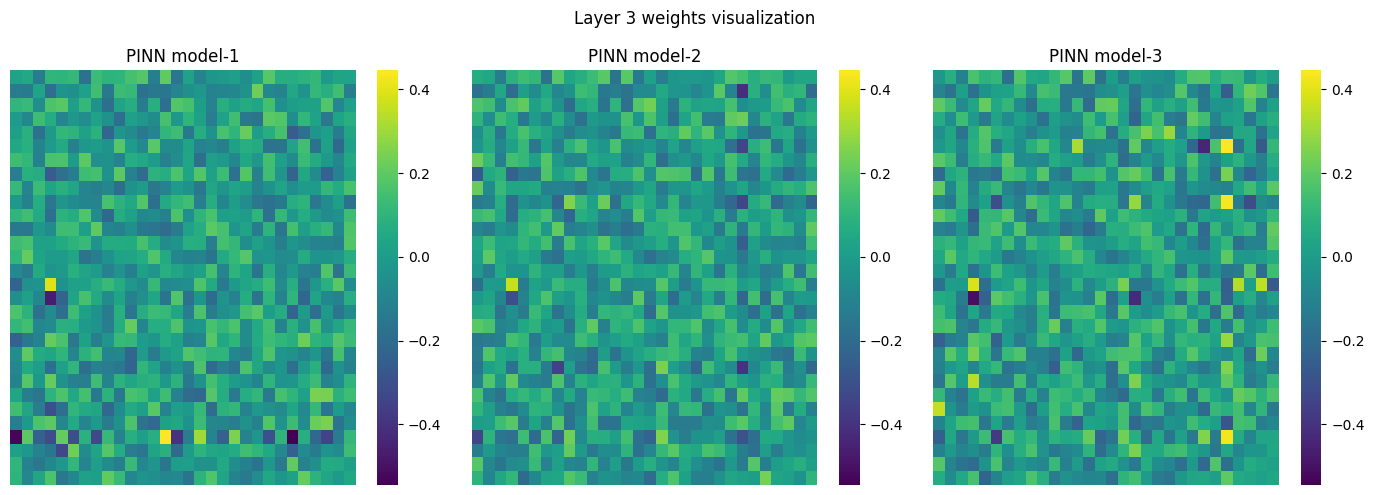

In [105]:
data_matrix1 = pinn1.layer3.weight.detach().numpy()
data_matrix2 = pinn2.layer3.weight.detach().numpy()
data_matrix3 = pinn3.layer3.weight.detach().numpy()
vmin = min(data_matrix1.min(), data_matrix2.min(), data_matrix3.min())
vmax = max(data_matrix1.max(), data_matrix2.max(), data_matrix3.max())

plt.figure(figsize=(14,5))
plt.suptitle("Layer 3 weights visualization")

plt.subplot(131)
plt.title("PINN model-1")
sns.heatmap(data_matrix1, annot=False, vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.subplot(132)
plt.title("PINN model-2")
sns.heatmap(data_matrix2, annot=False,  vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.subplot(133)
plt.title("PINN model-3")
sns.heatmap(data_matrix3, annot=False,  vmax=vmax, vmin=vmin, cmap='viridis', xticklabels=False, yticklabels=False)

plt.tight_layout()
plt.show()